In [1]:
import scanpy as sc
import pandas as pd
import scvi
import numpy as np
import pandas as pd
import seaborn as sns

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata_integrate_raw = sc.read_h5ad('adata_integrate_raw.h5ad')
scvi.model.SCVI.setup_anndata(adata_integrate_raw, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])
## save model after training finish
dir_path = '/data2/ZenNa/DFU_Project/Code/Model' 
model = scvi.model.SCVI.load(dir_path, adata_integrate_raw)


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     File /data2/ZenNa/DFU_Project/Code/Model/model.pt already downloaded                                      


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/uma

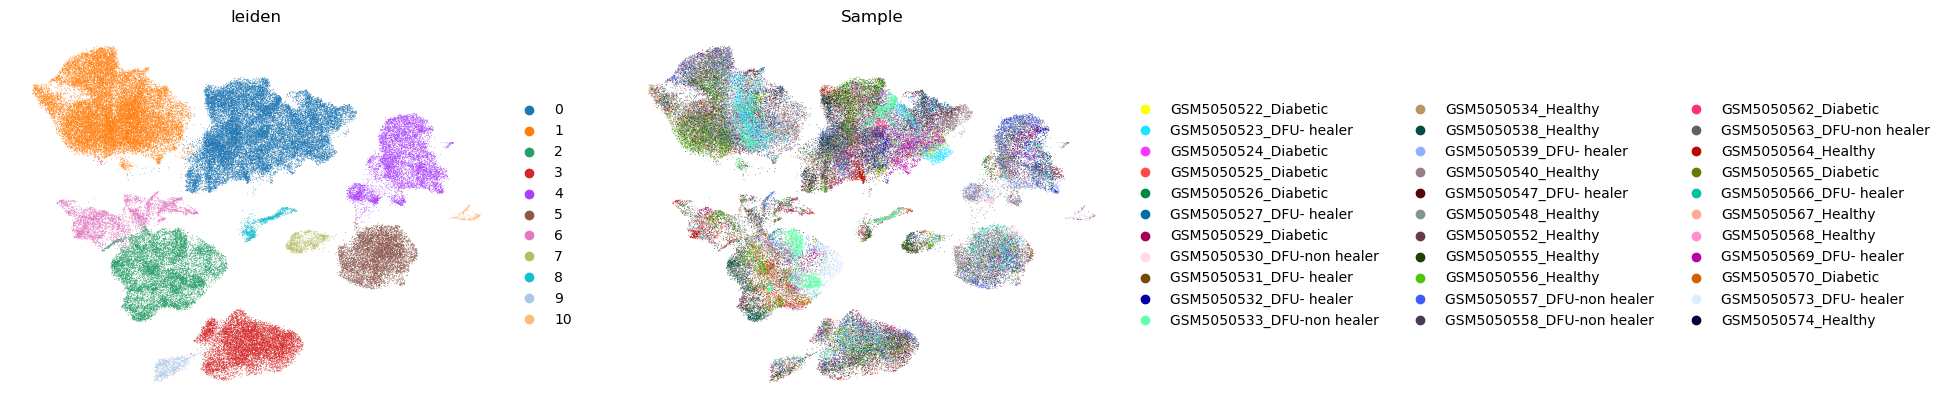

In [3]:
adata_integrate_raw.obsm['X_scVI'] = model.get_latent_representation()
adata_integrate_raw.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
sc.pp.neighbors(adata_integrate_raw, use_rep = 'X_scVI')
sc.tl.umap(adata_integrate_raw)
sc.tl.leiden(adata_integrate_raw, resolution = 0.2)
sc.pl.umap(adata_integrate_raw, color = ['leiden', 'Sample'], frameon = False)

In [4]:
sc.tl.rank_genes_groups(adata_integrate_raw, 'leiden')

In [5]:
markers = sc.get.rank_genes_groups_df(adata_integrate_raw, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

group    names      scores  logfoldchanges     pvals  pvals_adj
0          0      DCN  477.635437        4.238130  0.000000   0.000000
1          0      LUM  381.410858        4.293679  0.000000   0.000000
2          0     MMP2  362.988586        4.824518  0.000000   0.000000
3          0      C1S  319.260010        3.586017  0.000000   0.000000
4          0   COL1A2  319.120209        3.173512  0.000000   0.000000
...      ...      ...         ...             ...       ...        ...
120118    10  HSD17B7    2.131061        0.869709  0.034120   0.048539
120119    10   TCEANC    2.124900        1.853776  0.034638   0.049223
120120    10     ELP5    2.120329        0.548872  0.035023   0.049723
120121    10   TBC1D9    2.119418        0.845115  0.035102   0.049823
120122    10   IMMP1L    2.118574        0.731170  0.035173   0.049918

[21229 rows x 6 columns]

In [6]:
markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi

DE...: 100%|████████████████████████████████████| 11/11 [01:35<00:00,  8.70s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
CLMP      0.9982        0.0018      6.318161  0.000137  0.000014   
DCN       0.9982        0.0018      6.318161  0.006719  0.000289   
DIRAS3    0.9964        0.0036      5.623212  0.000073  0.000005   
SRPX2     0.9964        0.0036      5.623212  0.000054  0.000004   
FBLN1     0.9960        0.0040      5.517450  0.001602  0.000070   
...          ...           ...           ...       ...       ...   
TVP23B    0.7424        0.2576      1.058480  0.000009  0.000010   
TOX4      0.7422        0.2578      1.057435  0.000042  0.000056   
GPANK1    0.7356        0.2644      1.023223  0.000022  0.000023   
PRKCSH    0.7338        0.2662      1.013989  0.000048  0.000059   
UBE2B     0.7244        0.2756      0.966393  0.000106  0.000139   

        pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
CLMP             0.0   0.25  3.536305    3.527658  1.229215  ...   1.119475   
DCN              0.0   0.25  5.094203    5.194600  1.832502  ...  56.186020   
DIRAS3           0.0   0.25  4.178780    4.231519  1.558900  ...   0.364111   
SRPX2            0.0   0.25  4.172422    4.149383  1.604396  ...   0.529688   
FBLN1            0.0   0.25  4.993446    5.031653  1.825565  ...  13.802471   
...              ...    ...       ...         ...       ...  ...        ...   
TVP23B           0.0   0.25 -0.240539   -0.204744  0.726077  ...   0.114407   
TOX4             0.0   0.25 -0.578877   -0.417897  0.843068  ...   0.228814   
GPANK1           0.0   0.25 -0.095722   -0.070219  0.712808  ...   0.220339   
PRKCSH           0.0   0.25 -0.309294   -0.309271  0.646694  ...   0.720339   
UBE2B            0.0   0.25 -0.461486   -0.369991  0.739686  ...   0.529661   

        raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
CLMP     0.012381               0.501745               0.009214   
DCN      1.184592               0.982279               0.297752   
DIRAS3   0.007038               0.191795               0.006003   
SRPX2    0.021010               0.295409               0.016718   
FBLN1    0.324177               0.883279               0.155652   
...           ...                    ...                    ...   
TVP23B   0.075631               0.101695               0.070009   
TOX4     0.406593               0.190678               0.294051   
GPANK1   0.178601               0.190678               0.149477   
PRKCSH   0.478537               0.470339               0.323502   
UBE2B    1.000762               0.338983               0.527542   

        raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
CLMP                1.260761              0.018019            True   
DCN                71.106865              1.756618            True   
DIRAS3              0.520384              0.011901            True   
SRPX2               0.536057              0.024602            True   
FBLN1              16.977221              0.483013            True   
...                      ...                   ...             ...   
TVP23B              0.107183              0.103907           False   
TOX4                0.227721              0.566794           False   
GPANK1              0.298733              0.254103           False   
PRKCSH              0.934213              0.642923           False   
UBE2B               0.628251              1.408839           False   

        comparison  group1 group2  
CLMP     0 vs Rest       0   Rest  
DCN      0 vs Rest       0   Rest  
DIRAS3   0 vs Rest       0   Rest  
SRPX2    0 vs Rest       0   Rest  
FBLN1    0 vs Rest       0   Rest  
...            ...     ...    ...  
TVP23B  10 vs Rest      10   Rest  
TOX4    10 vs Rest      10   Rest  
GPANK1  10 vs Rest      10   Rest  
PRKCSH  10 vs Rest      10   Rest  
UBE2B   10 vs Rest      10   Rest  

[130636 rows x 22 columns]

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


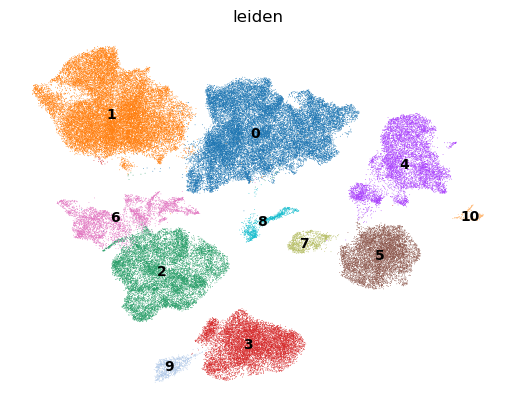

In [7]:
sc.pl.umap(adata_integrate_raw, color = ['leiden'], frameon = False, legend_loc = "on data")

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


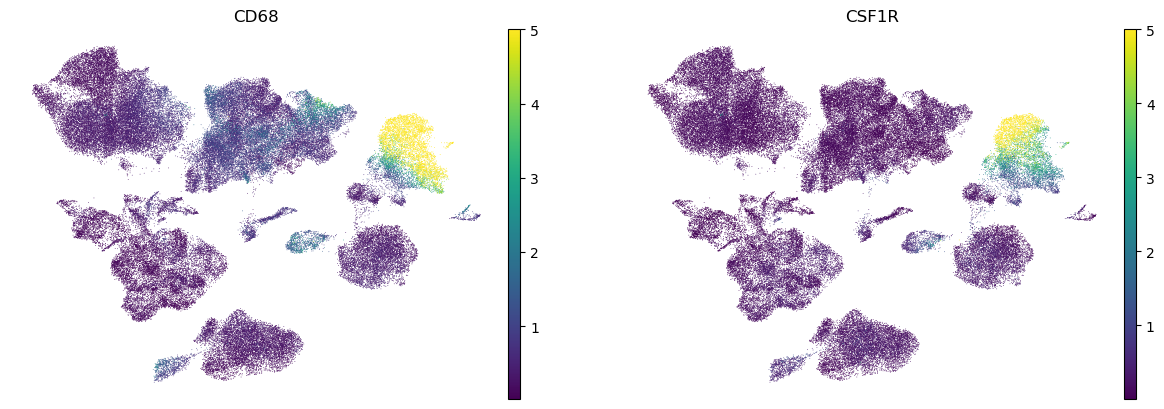

In [8]:
sc.pl.umap(adata_integrate_raw, color = ['CD68', 'CSF1R'], frameon = False, layer = 'scvi_normalized', vmax = 5) #M2 macrophage


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


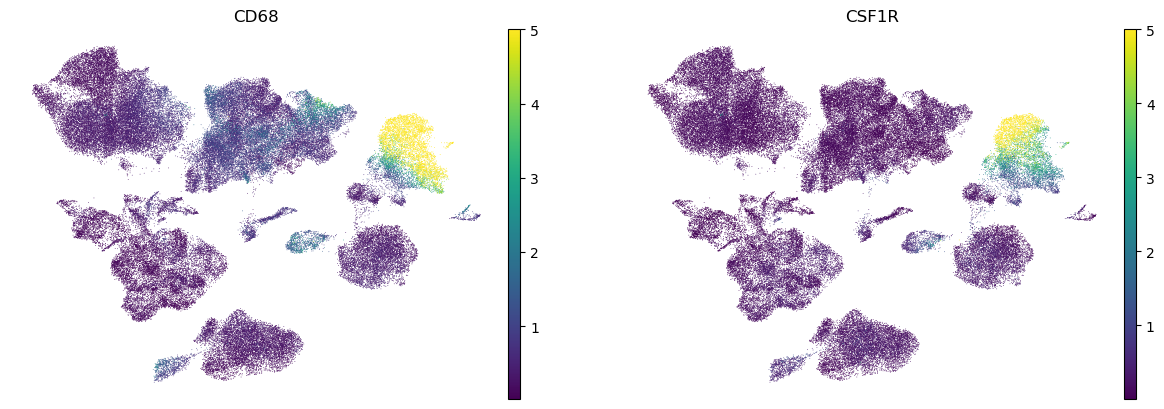

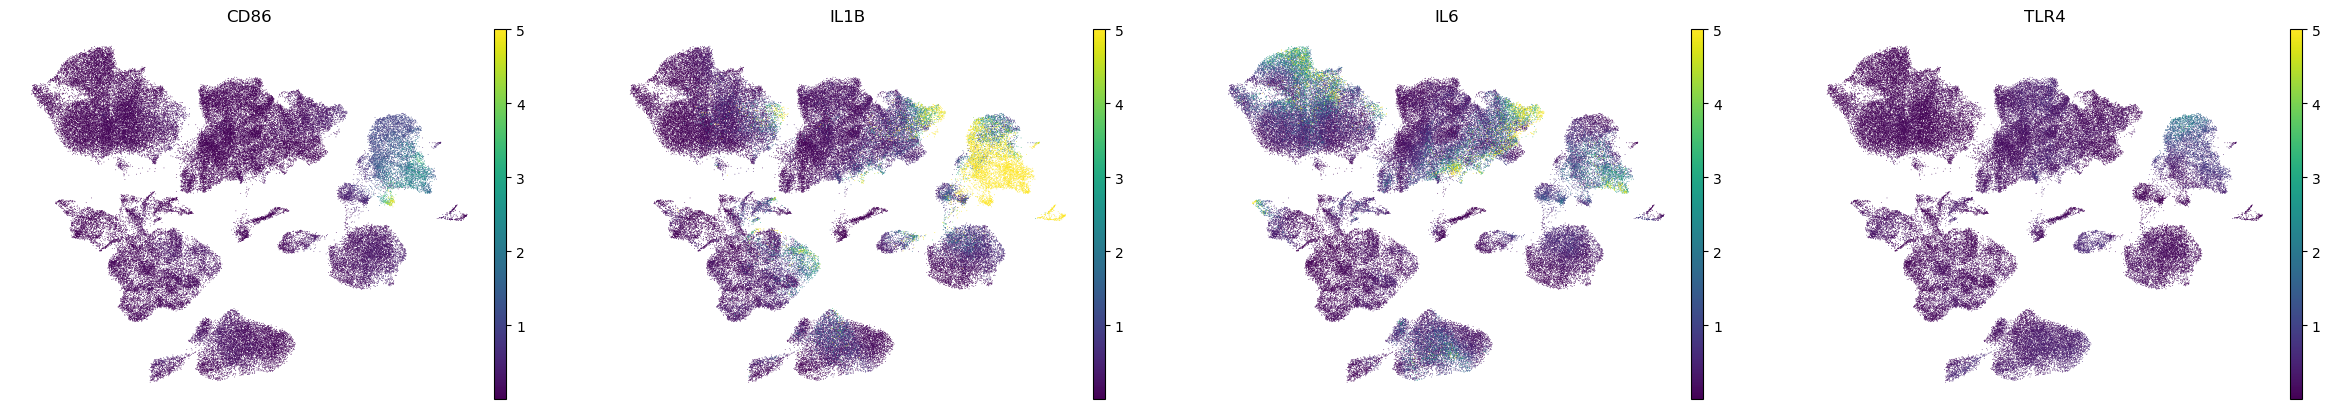

In [10]:
sc.pl.umap(adata_integrate_raw, color = ['CD68', 'CSF1R'], frameon = False, layer = 'scvi_normalized', vmax = 5) #M2 macrophage-6
sc.pl.umap(adata_integrate_raw, color = ['CD86', 'IL1B', 'IL6','TLR4'], frameon = False, layer = 'scvi_normalized', vmax = 5) #M1 macrophage


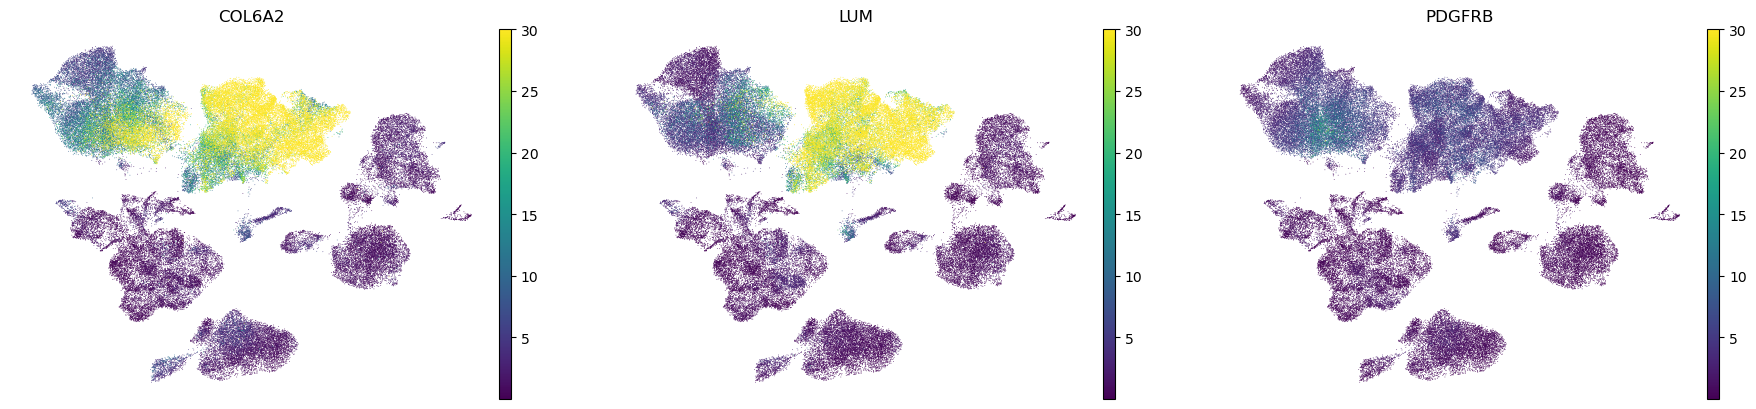

In [11]:
sc.pl.umap(adata_integrate_raw, color = ['COL6A2', 'LUM','PDGFRB'], frameon = False, layer = 'scvi_normalized', vmax = 30)  #Fibroblast 0 4


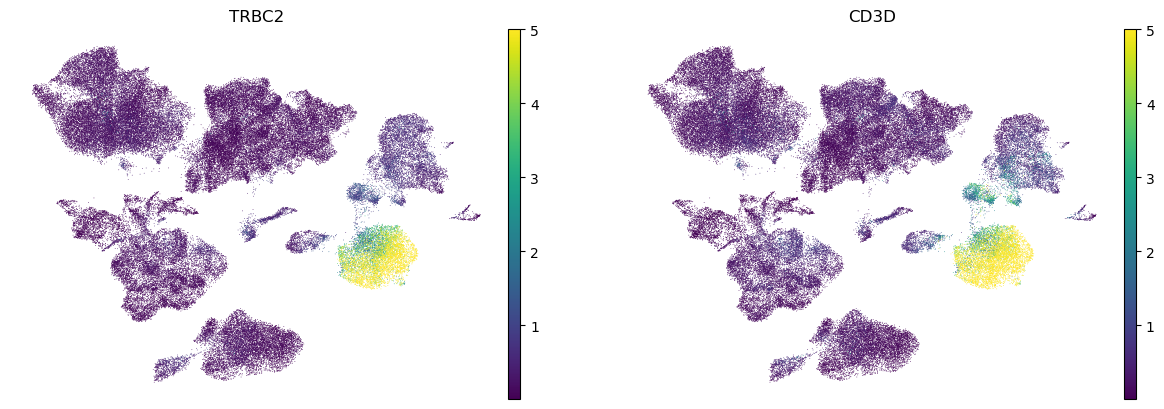

In [12]:
sc.pl.umap(adata_integrate_raw, color = ['TRBC2', 'CD3D'], frameon = False, layer = 'scvi_normalized', vmax = 5) #Tcell 


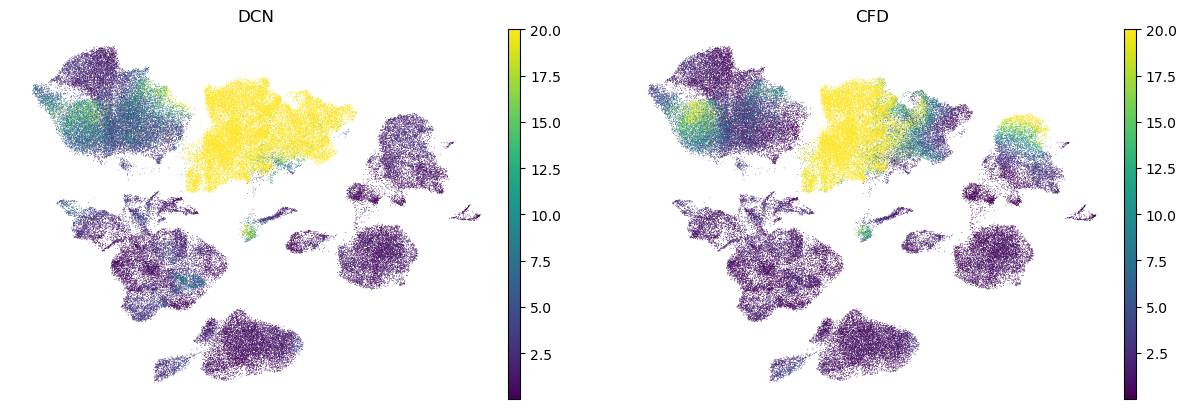

In [13]:
sc.pl.umap(adata_integrate_raw, color = ['DCN','CFD'], frameon = False, layer = 'scvi_normalized', vmax = 20) #Fibrobast

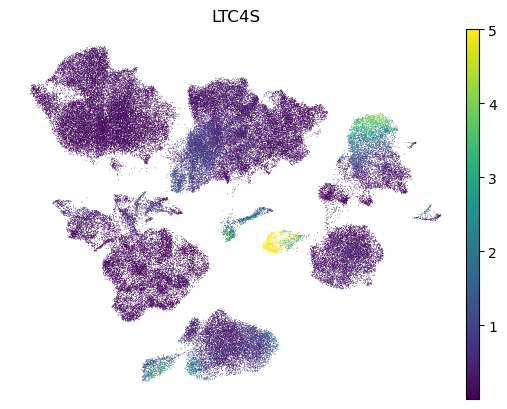

In [14]:
sc.pl.umap(adata_integrate_raw, color = ['LTC4S'], frameon = False, layer = 'scvi_normalized', vmax = 5) #Mastcell


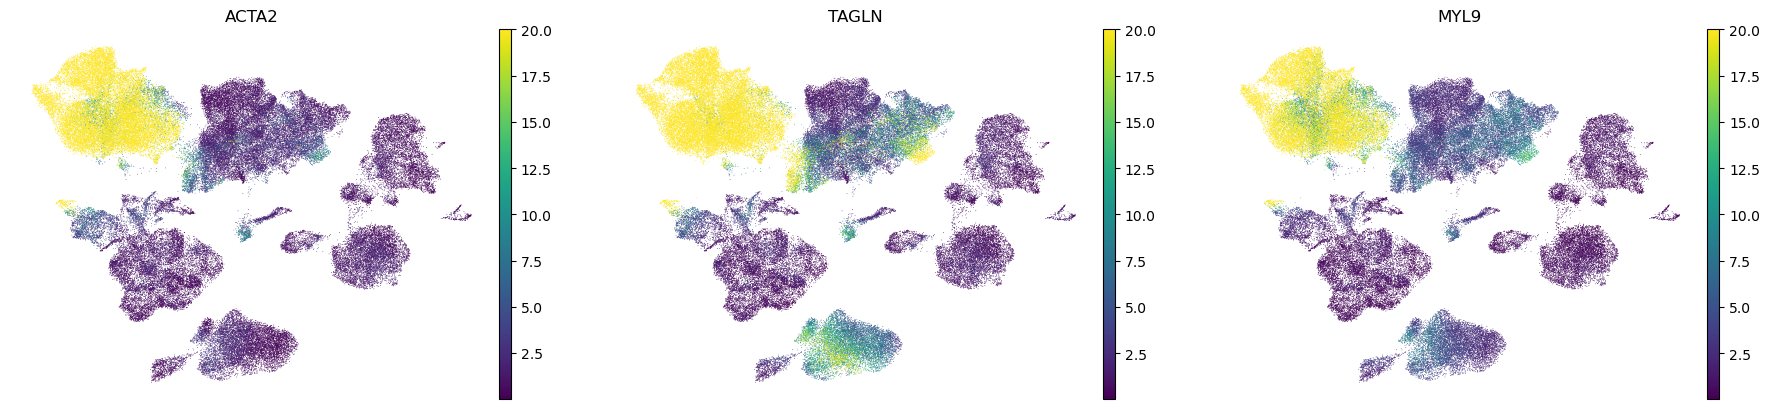

In [16]:
sc.pl.umap(adata_integrate_raw, color = ['ACTA2','TAGLN','MYL9'], frameon = False, layer = 'scvi_normalized', vmax = 20) #SMC

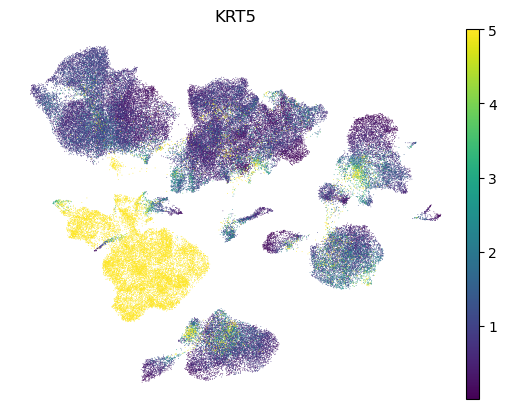

In [17]:
sc.pl.umap(adata_integrate_raw, color = ['KRT5'], frameon = False, layer = 'scvi_normalized', vmax = 5) #BasalKera

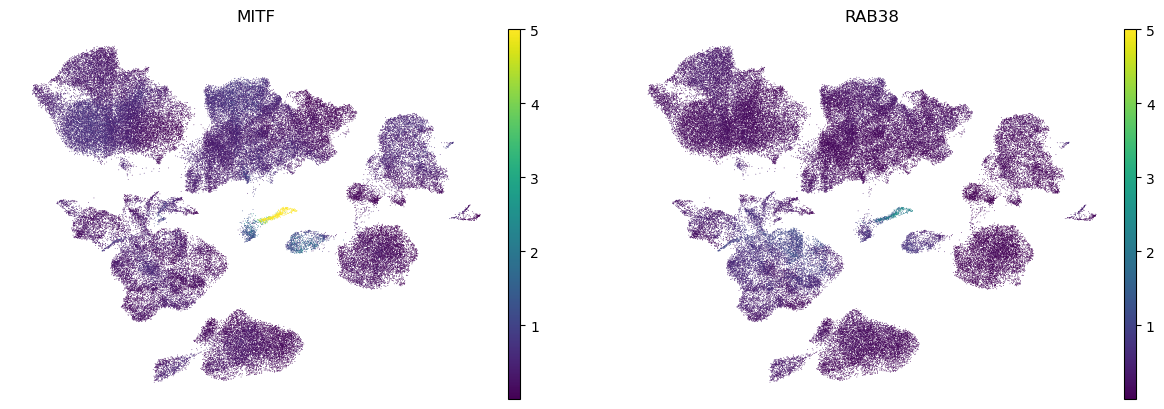

In [18]:
sc.pl.umap(adata_integrate_raw, color = ['MITF','RAB38'], frameon = False, layer = 'scvi_normalized', vmax = 5) #Melanocytes

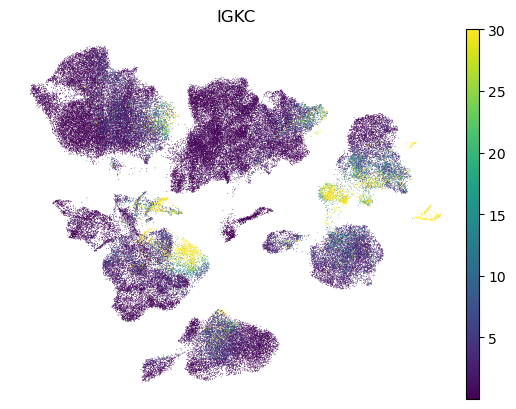

In [19]:
sc.pl.umap(adata_integrate_raw, color = ['IGKC'], frameon = False, layer = 'scvi_normalized', vmax = 30) #erythroid-like 

In [22]:
cell_type = {"0":"Fibroblast",
"1":"SMC",
"2":"Basalkera",
"3":"VasEpithelial",
"4":"Macrophage",
"5":"Tcell",
"6":"Basalkera",
"7":"Mastcell",
"8":"Melanocytes",
"9":"VasEpithelial",
"10":"Erythroid-like"}

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


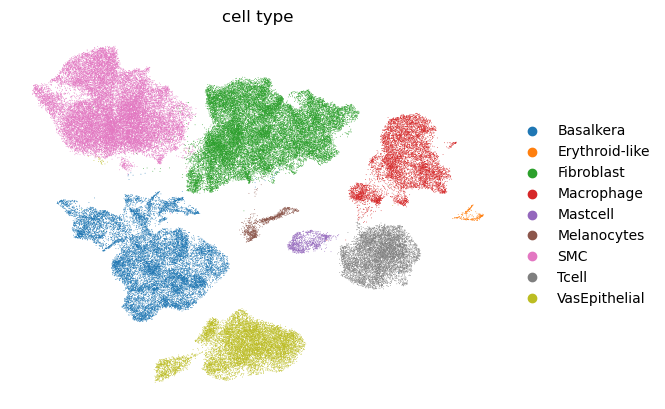

In [23]:
adata_integrate_raw.obs['cell type'] = adata_integrate_raw.obs.leiden.map(cell_type)
sc.pl.umap(adata_integrate_raw, color = ['cell type'], frameon = False)

In [ ]:
sc.pl.umap(adata_integrate_raw, color = ['cell type'], frameon = False)


In [24]:
adata_integrate_raw

AnnData object with n_obs × n_vars = 92424 × 11876
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell type_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [25]:
adata_integrate_raw.obs.Sample.unique().tolist()


['GSM5050567_Healthy',
 'GSM5050534_Healthy',
 'GSM5050547_DFU- healer',
 'GSM5050563_DFU-non healer',
 'GSM5050552_Healthy',
 'GSM5050525_Diabetic',
 'GSM5050531_DFU- healer',
 'GSM5050530_DFU-non healer',
 'GSM5050529_Diabetic',
 'GSM5050538_Healthy',
 'GSM5050565_Diabetic',
 'GSM5050574_Healthy',
 'GSM5050558_DFU-non healer',
 'GSM5050539_DFU- healer',
 'GSM5050527_DFU- healer',
 'GSM5050524_Diabetic',
 'GSM5050562_Diabetic',
 'GSM5050557_DFU-non healer',
 'GSM5050532_DFU- healer',
 'GSM5050548_Healthy',
 'GSM5050564_Healthy',
 'GSM5050566_DFU- healer',
 'GSM5050555_Healthy',
 'GSM5050569_DFU- healer',
 'GSM5050573_DFU- healer',
 'GSM5050540_Healthy',
 'GSM5050568_Healthy',
 'GSM5050570_Diabetic',
 'GSM5050556_Healthy',
 'GSM5050526_Diabetic',
 'GSM5050523_DFU- healer',
 'GSM5050533_DFU-non healer',
 'GSM5050522_Diabetic']

# Counting cell

In [26]:
def map_condition(x):
    if 'Healthy' in x:
        return 'Healthy'
    elif 'Diabetic' in x:
        return 'Diabetic'
    elif 'DFU- healer' in x:
        return 'DFU- healer'
    else:
        return 'DFU-non healer'

In [27]:
adata_integrate_raw.obs['condition'] = adata_integrate_raw.obs.Sample.map(map_condition)
print(adata_integrate_raw.obs)

                                 Sample  doublet  n_genes  n_genes_by_counts  \
AAACCCAAGGTCGAGT-1   GSM5050567_Healthy    False     7618               7618   
AAACCCATCCCATTTA-1   GSM5050567_Healthy    False     4428               4428   
AAACGAAAGCATCCTA-1   GSM5050567_Healthy    False      749                749   
AAACGAATCGATGCAT-1   GSM5050567_Healthy    False     2549               2549   
AAAGGATAGCTTCATG-1   GSM5050567_Healthy    False     3853               3853   
...                                 ...      ...      ...                ...   
TTTGCGCTCCTAGTGA    GSM5050522_Diabetic    False     1006               1006   
TTTGGTTAGGGCTTGA    GSM5050522_Diabetic    False     1329               1329   
TTTGGTTGTGAGTGAC    GSM5050522_Diabetic    False      709                709   
TTTGTCAAGATGTCGG    GSM5050522_Diabetic    False     1537               1537   
TTTGTCATCTTCGAGA    GSM5050522_Diabetic    False     1790               1790   

                    total_counts  total

In [28]:
num_tot_cells = adata_integrate_raw.obs.groupby(['Sample']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.doublet))
num_tot_cells

/tmp/ipykernel_930588/2471726013.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata_integrate_raw.obs.groupby(['Sample']).count()


{'GSM5050522_Diabetic': 965,
 'GSM5050523_DFU- healer': 3871,
 'GSM5050524_Diabetic': 531,
 'GSM5050525_Diabetic': 1944,
 'GSM5050526_Diabetic': 990,
 'GSM5050527_DFU- healer': 2807,
 'GSM5050529_Diabetic': 2577,
 'GSM5050530_DFU-non healer': 2233,
 'GSM5050531_DFU- healer': 1739,
 'GSM5050532_DFU- healer': 2368,
 'GSM5050533_DFU-non healer': 4204,
 'GSM5050534_Healthy': 4728,
 'GSM5050538_Healthy': 5291,
 'GSM5050539_DFU- healer': 2205,
 'GSM5050540_Healthy': 2863,
 'GSM5050547_DFU- healer': 4537,
 'GSM5050548_Healthy': 3444,
 'GSM5050552_Healthy': 2433,
 'GSM5050555_Healthy': 3395,
 'GSM5050556_Healthy': 4108,
 'GSM5050557_DFU-non healer': 4182,
 'GSM5050558_DFU-non healer': 3344,
 'GSM5050562_Diabetic': 1445,
 'GSM5050563_DFU-non healer': 2841,
 'GSM5050564_Healthy': 2538,
 'GSM5050565_Diabetic': 2388,
 'GSM5050566_DFU- healer': 2190,
 'GSM5050567_Healthy': 1070,
 'GSM5050568_Healthy': 2032,
 'GSM5050569_DFU- healer': 4117,
 'GSM5050570_Diabetic': 1625,
 'GSM5050573_DFU- healer': 39

In [29]:
cell_type_counts = adata_integrate_raw.obs.groupby(['Sample', 'condition', 'cell type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
#cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
print(cell_type_counts)

                  Sample condition      cell type  doublet  n_genes  \
0    GSM5050522_Diabetic  Diabetic      Basalkera        3        3   
1    GSM5050522_Diabetic  Diabetic     Fibroblast      522      522   
2    GSM5050522_Diabetic  Diabetic     Macrophage       32       32   
3    GSM5050522_Diabetic  Diabetic       Mastcell        3        3   
4    GSM5050522_Diabetic  Diabetic            SMC      179      179   
..                   ...       ...            ...      ...      ...   
260   GSM5050574_Healthy   Healthy       Mastcell       45       45   
261   GSM5050574_Healthy   Healthy    Melanocytes       60       60   
262   GSM5050574_Healthy   Healthy            SMC      486      486   
263   GSM5050574_Healthy   Healthy          Tcell      131      131   
264   GSM5050574_Healthy   Healthy  VasEpithelial      796      796   

     n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
0                    3             3                3              3   
1  

/tmp/ipykernel_930588/672114786.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata_integrate_raw.obs.groupby(['Sample', 'condition', 'cell type']).count()


In [30]:
cell_type_counts['total_cells'] = cell_type_counts.Sample.map(num_tot_cells).astype(int)

cell_type_counts['frequency'] = cell_type_counts.doublet / cell_type_counts.total_cells

cell_type_counts

Sample condition      cell type  doublet  n_genes  \
0    GSM5050522_Diabetic  Diabetic      Basalkera        3        3   
1    GSM5050522_Diabetic  Diabetic     Fibroblast      522      522   
2    GSM5050522_Diabetic  Diabetic     Macrophage       32       32   
3    GSM5050522_Diabetic  Diabetic       Mastcell        3        3   
4    GSM5050522_Diabetic  Diabetic            SMC      179      179   
..                   ...       ...            ...      ...      ...   
260   GSM5050574_Healthy   Healthy       Mastcell       45       45   
261   GSM5050574_Healthy   Healthy    Melanocytes       60       60   
262   GSM5050574_Healthy   Healthy            SMC      486      486   
263   GSM5050574_Healthy   Healthy          Tcell      131      131   
264   GSM5050574_Healthy   Healthy  VasEpithelial      796      796   

     n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
0                    3             3                3              3   
1                  522           522              522            522   
2                   32            32               32             32   
3                    3             3                3              3   
4                  179           179              179            179   
..                 ...           ...              ...            ...   
260                 45            45               45             45   
261                 60            60               60             60   
262                486           486              486            486   
263                131           131              131            131   
264                796           796              796            796   

     total_counts_ribo  pct_counts_ribo  _scvi_batch  _scvi_labels  leiden  \
0                    3                3            3             3       3   
1                  522              522          522           522     522   
2                   32               32           32            32      32   
3                    3                3            3             3       3   
4                  179              179          179           179     179   
..                 ...              ...          ...           ...     ...   
260                 45               45           45            45      45   
261                 60               60           60            60      60   
262                486              486          486           486     486   
263                131              131          131           131     131   
264                796              796          796           796     796   

     _scvi_raw_norm_scaling  total_cells  frequency  
0                         3          965   0.003109  
1                       522          965   0.540933  
2                        32          965   0.033161  
3                         3          965   0.003109  
4                       179          965   0.185492  
..                      ...          ...        ...  
260                      45         3460   0.013006  
261                      60         3460   0.017341  
262                     486         3460   0.140462  
263                     131         3460   0.037861  
264                     796         3460   0.230058  

[265 rows x 17 columns]

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/seaborn/cat

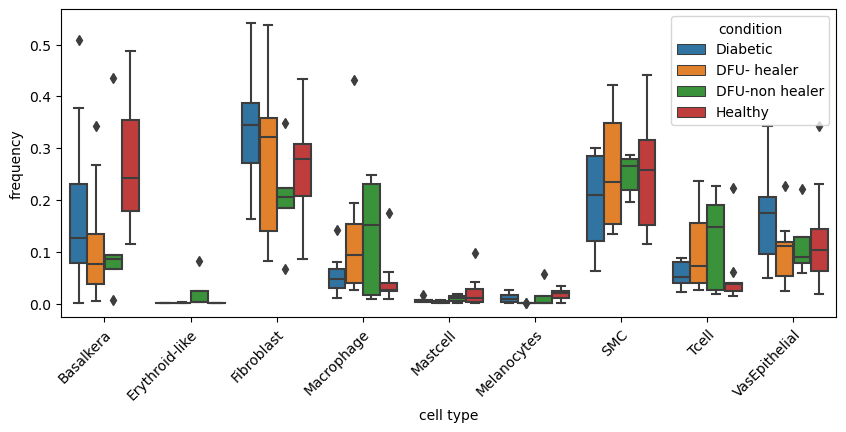

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,4))

ax = sns.boxplot(data = cell_type_counts, x = 'cell type', y = 'frequency', hue = 'condition')

plt.xticks(rotation = 45, rotation_mode = 'anchor', ha = 'right')

plt.show()

#DE analysis

In [32]:
group_column = 'condition'
groups_to_extract = ['DFU- healer', 'DFU-non healer']
filter_adata_integrate_raw = adata_integrate_raw[adata_integrate_raw.obs['condition'].isin(groups_to_extract)]
print(filter_adata_integrate_raw.obs)

                                     Sample  doublet  n_genes  \
AAACCCACAACCAACT     GSM5050547_DFU- healer    False     2075   
AAACCCACACAAAGCG     GSM5050547_DFU- healer    False     2104   
AAACCCATCGGTAGGA     GSM5050547_DFU- healer    False     4383   
AAACGAAAGGAGACCT     GSM5050547_DFU- healer    False     1709   
AAACGAACAGAGTTCT     GSM5050547_DFU- healer    False     1907   
...                                     ...      ...      ...   
TTTGGTTTCTGCCCTA  GSM5050533_DFU-non healer    False     1592   
TTTGGTTTCTTGTCAT  GSM5050533_DFU-non healer    False      749   
TTTGTCACATAAGACA  GSM5050533_DFU-non healer    False     1055   
TTTGTCAGTCTGCCAG  GSM5050533_DFU-non healer    False     2227   
TTTGTCAGTGTAAGTA  GSM5050533_DFU-non healer    False     1664   

                  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCACAACCAACT               2075        5799.0              0.0   
AAACCCACACAAAGCG               2104        5921.0              0.0   
AAACCCATC

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [34]:
subset_cell_Macrophage = filter_adata_integrate_raw[filter_adata_integrate_raw.obs['cell type'].isin(['Macrophage'])].copy()

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [36]:
subset_cell_Macrophage.obs

Sample  doublet  n_genes  \
AAACGAACAGAGTTCT     GSM5050547_DFU- healer    False     1907   
AAAGAACCATGCCGCA     GSM5050547_DFU- healer    False     1740   
AAAGGTAGTCACTACA     GSM5050547_DFU- healer    False     1239   
AAAGGTATCGCTGACG     GSM5050547_DFU- healer    False     1338   
AAAGTGATCACTGTTT     GSM5050547_DFU- healer    False     1754   
...                                     ...      ...      ...   
TACCTATTCTGCGTAA  GSM5050533_DFU-non healer    False      978   
TATCAGGGTATGAAAC  GSM5050533_DFU-non healer    False     2093   
TCGGTAAAGTCCTCCT  GSM5050533_DFU-non healer    False      402   
TGCCAAAAGGCAGGTT  GSM5050533_DFU-non healer    False      353   
TTTATGCAGGCCCGTT  GSM5050533_DFU-non healer    False     1704   

                  n_genes_by_counts  total_counts  total_counts_mt  \
AAACGAACAGAGTTCT               1907        7347.0              0.0   
AAAGAACCATGCCGCA               1740        4540.0              0.0   
AAAGGTAGTCACTACA               1239        3278.0              0.0   
AAAGGTATCGCTGACG               1338        3826.0              0.0   
AAAGTGATCACTGTTT               1754        4487.0              0.0   
...                             ...           ...              ...   
TACCTATTCTGCGTAA                978        2417.0              0.0   
TATCAGGGTATGAAAC               2093        8352.0              0.0   
TCGGTAAAGTCCTCCT                402         943.0              0.0   
TGCCAAAAGGCAGGTT                353         853.0              0.0   
TTTATGCAGGCCCGTT               1704        6631.0              0.0   

                  pct_counts_mt  total_counts_ribo  pct_counts_ribo  \
AAACGAACAGAGTTCT            0.0             1358.0        18.483734   
AAAGAACCATGCCGCA            0.0              501.0        11.035242   
AAAGGTAGTCACTACA            0.0              134.0         4.087858   
AAAGGTATCGCTGACG            0.0              334.0         8.729744   
AAAGTGATCACTGTTT            0.0              322.0         7.176287   
...                         ...                ...              ...   
TACCTATTCTGCGTAA            0.0              507.0        20.976418   
TATCAGGGTATGAAAC            0.0             2257.0        27.023468   
TCGGTAAAGTCCTCCT            0.0              257.0        27.253447   
TGCCAAAAGGCAGGTT            0.0              252.0        29.542789   
TTTATGCAGGCCCGTT            0.0             1697.0        25.591915   

                  _scvi_batch  _scvi_labels leiden  _scvi_raw_norm_scaling  \
AAACGAACAGAGTTCT            0             0      4                1.391208   
AAAGAACCATGCCGCA            0             0      4                2.289901   
AAAGGTAGTCACTACA            0             0      4                3.205128   
AAAGGTATCGCTGACG            0             0      4                2.712968   
AAAGTGATCACTGTTT            0             0      4                2.314815   
...                       ...           ...    ...                     ...   
TACCTATTCTGCGTAA            0             0      4                4.312204   
TATCAGGGTATGAAAC            0             0      4                1.226542   
TCGGTAAAGTCCTCCT            0             0      4               11.025359   
TGCCAAAAGGCAGGTT            0             0      4               12.150669   
TTTATGCAGGCCCGTT            0             0      4                1.569859   

                   cell type       condition  
AAACGAACAGAGTTCT  Macrophage     DFU- healer  
AAAGAACCATGCCGCA  Macrophage     DFU- healer  
AAAGGTAGTCACTACA  Macrophage     DFU- healer  
AAAGGTATCGCTGACG  Macrophage     DFU- healer  
AAAGTGATCACTGTTT  Macrophage     DFU- healer  
...                      ...             ...  
TACCTATTCTGCGTAA  Macrophage  DFU-non healer  
TATCAGGGTATGAAAC  Macrophage  DFU-non healer  
TCGGTAAAGTCCTCCT  Macrophage  DFU-non healer  
TGCCAAAAGGCAGGTT  Macrophage  DFU-non healer  
TTTATGCAGGCCCGTT  Macrophage  DFU-non healer  

[5266 rows x 15 columns]

In [51]:
sc.pp.filter_genes(subset_cell_Macrophage, min_cells = 3)

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatte

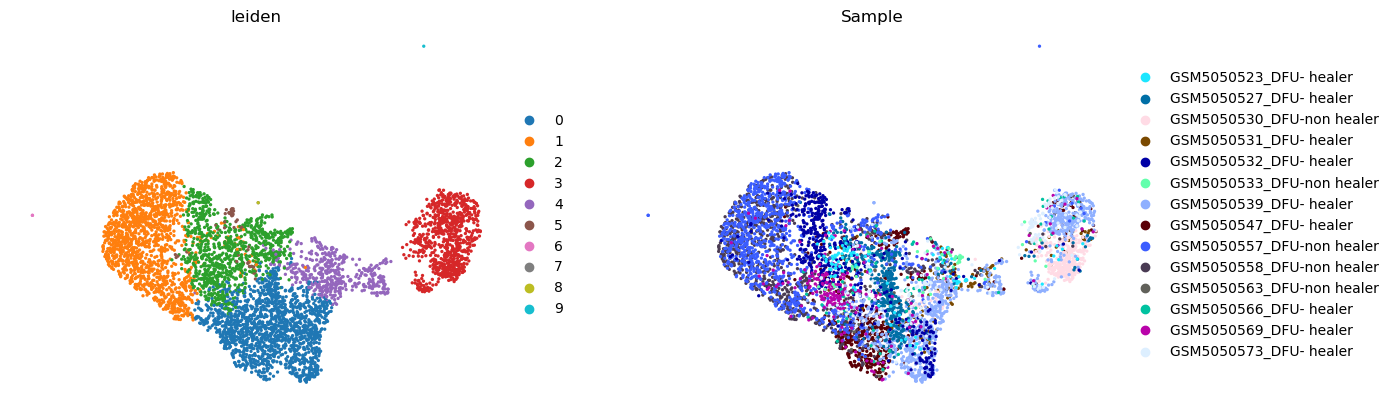

In [57]:
sc.tl.umap(subset_cell_Macrophage)
sc.tl.leiden(subset_cell_Macrophage, resolution = 0.2)
sc.pl.umap(subset_cell_Macrophage, color = ['leiden', 'Sample'], frameon = False)

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


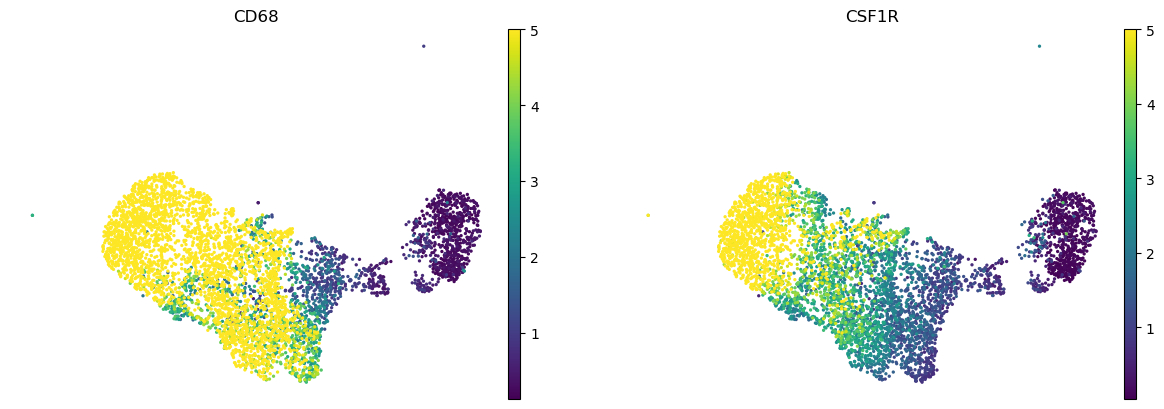

In [58]:
sc.pl.umap(subset_cell_Macrophage, color = ['CD68', 'CSF1R'], frameon = False, layer = 'scvi_normalized', vmax = 5) #M2 macrophage-6

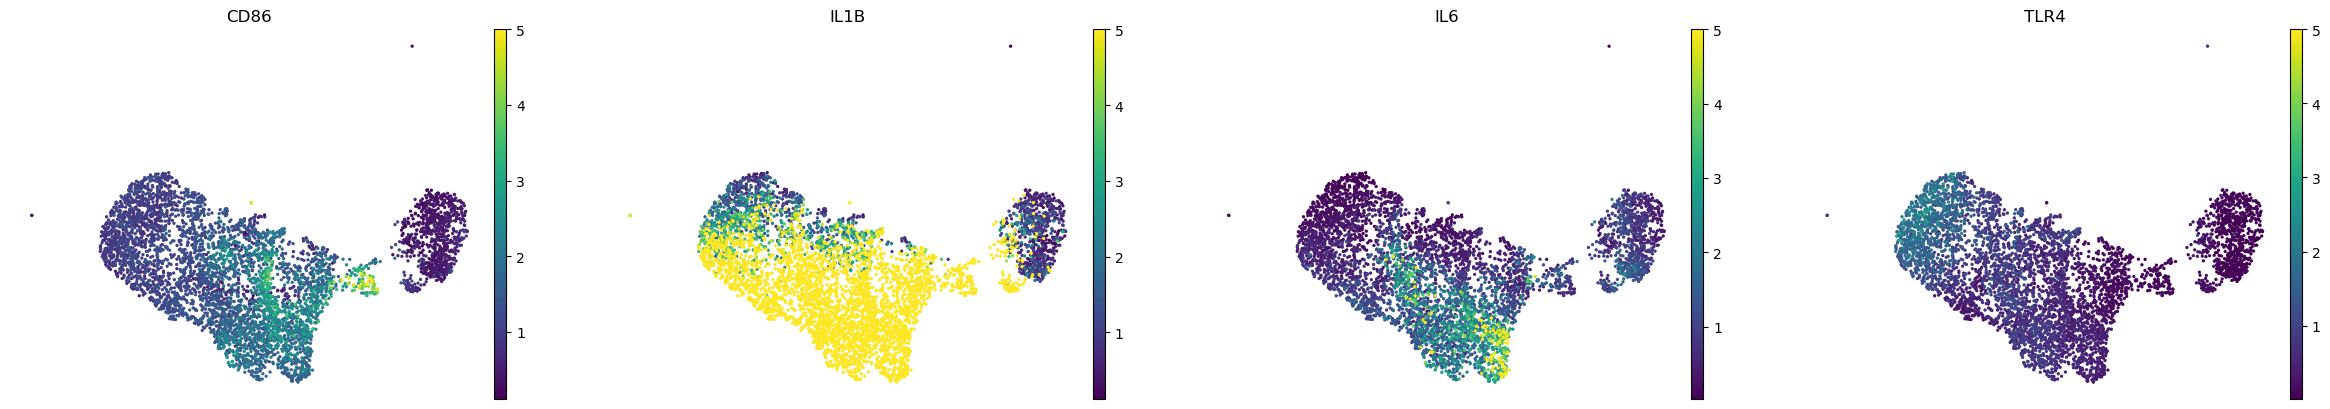

In [59]:
sc.pl.umap(subset_cell_Macrophage, color = ['CD86', 'IL1B', 'IL6','TLR4'], frameon = False, layer = 'scvi_normalized', vmax = 5) #M1 macrophage


In [47]:
# Create a new filtered adata object without these cells
subset_cell_Macrophage_filtered = subset_cell_Macrophage[~subset_cell_Macrophage.obs.index.isin(cells_to_remove)].copy()


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [60]:
subset_cell_Fibroblast = filter_adata_integrate_raw[filter_adata_integrate_raw.obs['cell type'].isin(['Fibroblast'])].copy()

/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [61]:
subset_cell_Fibroblast 

AnnData object with n_obs × n_vars = 12049 × 11876
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type', 'condition'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell type_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [66]:
sc.pp.highly_variable_genes(subset_cell_Fibroblast , n_top_genes = 100)


/data1/tools/anaconda3/envs/zennaenv/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [67]:
subset_cell_Fibroblast .var

n_cells  highly_variable     means  dispersions  dispersions_norm
LINC00115      1778            False  0.053012     1.515525          0.272528
FAM41C          879            False  0.013817     1.184677         -1.177019
NOC2L         19692            False  0.550143     1.319005          0.005243
KLHL17         2080            False  0.081590     1.359371         -0.411632
PLEKHN1        3368            False  0.055389     1.885051          1.891537
...             ...              ...       ...          ...               ...
MT-ND6        13215            False  0.486731     1.618234          1.895339
MT-CYB        90416            False  2.857047     1.227918          0.956427
AL592183.1     3389            False  0.037586     1.523199          0.306150
AC007325.4     6355            False  0.093443     1.446639         -0.029282
AC240274.1     4263            False  0.236721     1.478637          0.502848

[11876 rows x 5 columns]

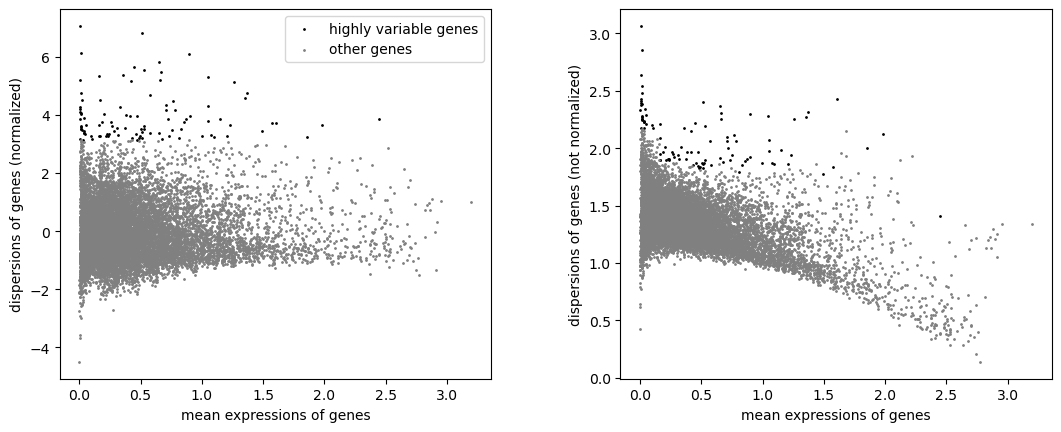

In [136]:
sc.pl.highly_variable_genes(subset_cell_Fibroblast)

In [138]:
highly_variable_gene_list = subset_cell_Fibroblast.var_names[subset_cell_Fibroblast.var['highly_variable']]
print(highly_variable_gene_list)


Index(['SFN', 'ACOT11', 'TACSTD2', 'CHI3L2', 'S100A9', 'HSPA6', 'RGS16',
       'PTGS2', 'ELF3', 'CHI3L1', 'G0S2', 'AGT', 'RN7SL832P', 'CYP26B1',
       'IGKC', 'ANKRD36C', 'ANKRD36', 'NR4A2', 'HAGLROS', 'IGFBP2', 'SCG2',
       'CLEC3B', 'COL7A1', 'WNT5A', 'PTX3', 'APOD', 'LINC00504', 'CXCL8',
       'CXCL1', 'CXCL3', 'CXCL2', 'SPARCL1', 'THBS4', 'TCF7', 'CXCL14', 'CD74',
       'DOCK2', 'F13A1', 'DSP', 'RBM24', 'HSPA1A', 'HLA-DRA', 'HLA-DRB1',
       'PI16', 'TNFAIP3', 'IL6', 'SFRP4', 'IGFBP3', 'TFPI2', 'SAP25',
       'AC058791.1', 'PTN', 'PCDH19', 'STC1', 'CLU', 'PI15', 'FABP4', 'CA2',
       'AQP3', 'CCL19', 'PIP5K1B', 'TLE4', 'GADD45G', 'PAPPA', 'PTGDS',
       'MS4A6A', 'GAL', 'TMEM254-AS1', 'C1RL-AS1', 'GPRC5A', 'NR4A1', 'KRT5',
       'IGF1', 'RNASE6', 'RPS6KL1', 'DIO2', 'GREM1', 'C15orf48', 'THSD4',
       'CRABP1', 'MAPK8IP3', 'LINC00920', 'CCL2', 'CCL3', 'KRT16', 'HOXB7',
       'APCDD1', 'SERPINB2', 'SYCP2', 'ABCA7', 'TNFSF14', 'SH2D3A', 'LDLR',
       'LGALS4', 'APOE', 'N

In [140]:
subset_cell_Fibroblast.obs


Sample  doublet  n_genes  \
AAACCCATCGGTAGGA     GSM5050547_DFU- healer    False     4383   
AAACGAATCTCACCCA     GSM5050547_DFU- healer    False     2752   
AAAGAACCACATGAAA     GSM5050547_DFU- healer    False     1757   
AAAGAACCATGGAATA     GSM5050547_DFU- healer    False     3281   
AAAGGATCAGCCTATA     GSM5050547_DFU- healer    False     2687   
...                                     ...      ...      ...   
TTTATGCCAGTAGAGC  GSM5050533_DFU-non healer    False     1583   
TTTCCTCCAGGGCATA  GSM5050533_DFU-non healer    False     1326   
TTTCCTCGTATATGAG  GSM5050533_DFU-non healer    False     1196   
TTTGCGCAGAGTGAGA  GSM5050533_DFU-non healer    False      871   
TTTGGTTAGCCTTGAT  GSM5050533_DFU-non healer    False     1412   

                  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCATCGGTAGGA               4383       18856.0              0.0   
AAACGAATCTCACCCA               2752        7857.0              0.0   
AAAGAACCACATGAAA               1757        5157.0              0.0   
AAAGAACCATGGAATA               3281       12411.0              0.0   
AAAGGATCAGCCTATA               2687        8467.0              0.0   
...                             ...           ...              ...   
TTTATGCCAGTAGAGC               1583        4467.0              0.0   
TTTCCTCCAGGGCATA               1326        3467.0              0.0   
TTTCCTCGTATATGAG               1196        2722.0              0.0   
TTTGCGCAGAGTGAGA                871        1715.0              0.0   
TTTGGTTAGCCTTGAT               1412        3457.0              0.0   

                  pct_counts_mt  total_counts_ribo  pct_counts_ribo  \
AAACCCATCGGTAGGA            0.0             2550.0        13.523547   
AAACGAATCTCACCCA            0.0             1023.0        13.020237   
AAAGAACCACATGAAA            0.0              768.0        14.892380   
AAAGAACCATGGAATA            0.0             2195.0        17.685925   
AAAGGATCAGCCTATA            0.0             1158.0        13.676627   
...                         ...                ...              ...   
TTTATGCCAGTAGAGC            0.0              775.0        17.349451   
TTTCCTCCAGGGCATA            0.0              902.0        26.016729   
TTTCCTCGTATATGAG            0.0              455.0        16.715651   
TTTGCGCAGAGTGAGA            0.0              286.0        16.676384   
TTTGGTTAGCCTTGAT            0.0              506.0        14.636968   

                  _scvi_batch  _scvi_labels leiden  _scvi_raw_norm_scaling  \
AAACCCATCGGTAGGA            0             0      0                0.549330   
AAACGAATCTCACCCA            0             0      0                1.313025   
AAAGAACCACATGAAA            0             0      0                2.101282   
AAAGAACCATGGAATA            0             0      0                0.825219   
AAAGGATCAGCCTATA            0             0      0                1.223990   
...                       ...           ...    ...                     ...   
TTTATGCCAGTAGAGC            0             0      0                2.310536   
TTTCCTCCAGGGCATA            0             0      0                2.970885   
TTTCCTCGTATATGAG            0             0      0                3.792188   
TTTGCGCAGAGTGAGA            0             0      0                6.049607   
TTTGGTTAGCCTTGAT            0             0      0                2.976191   

                   cell type       condition  
AAACCCATCGGTAGGA  Fibroblast     DFU- healer  
AAACGAATCTCACCCA  Fibroblast     DFU- healer  
AAAGAACCACATGAAA  Fibroblast     DFU- healer  
AAAGAACCATGGAATA  Fibroblast     DFU- healer  
AAAGGATCAGCCTATA  Fibroblast     DFU- healer  
...                      ...             ...  
TTTATGCCAGTAGAGC  Fibroblast  DFU-non healer  
TTTCCTCCAGGGCATA  Fibroblast  DFU-non healer  
TTTCCTCGTATATGAG  Fibroblast  DFU-non healer  
TTTGCGCAGAGTGAGA  Fibroblast  DFU-non healer  
TTTGGTTAGCCTTGAT  Fibroblast  DFU-non healer  

[12049 rows x 15 columns]

In [141]:
print(subset_cell_Fibroblast.var)

            n_cells  highly_variable     means  dispersions  dispersions_norm
LINC00115      1778            False  0.053012     1.515525          0.272528
FAM41C          879            False  0.013817     1.184677         -1.177019
NOC2L         19692            False  0.550143     1.319005          0.005243
KLHL17         2080            False  0.081590     1.359371         -0.411632
PLEKHN1        3368            False  0.055389     1.885051          1.891537
...             ...              ...       ...          ...               ...
MT-ND6        13215            False  0.486731     1.618234          1.895339
MT-CYB        90416            False  2.857047     1.227918          0.956427
AL592183.1     3389            False  0.037586     1.523199          0.306150
AC007325.4     6355            False  0.093443     1.446639         -0.029282
AC240274.1     4263            False  0.236721     1.478637          0.502848

[11876 rows x 5 columns]


In [157]:
subset_cell_Fibroblast

AnnData object with n_obs × n_vars = 12049 × 11876
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cell type', 'condition'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'cell type_colors', 'hvg'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap', 'X_pca'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [142]:
# Example using t-test 
healer_group = subset_cell_Fibroblast.obs[subset_cell_Fibroblast.obs['condition'] == 'DFU- healer']
non_healer_group = subset_cell_Fibroblast.obs[subset_cell_Fibroblast.obs['condition'] == 'DFU-non healer']


In [151]:
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [155]:
# Initialize empty lists to store results
pvalues = []
log_fold_changes = []

In [158]:
sc.pp.neighbors(subset_cell_Fibroblast, n_neighbors =10, n_pcs =20)

In [159]:
sc.tl.umap(subset_cell_Fibroblast)